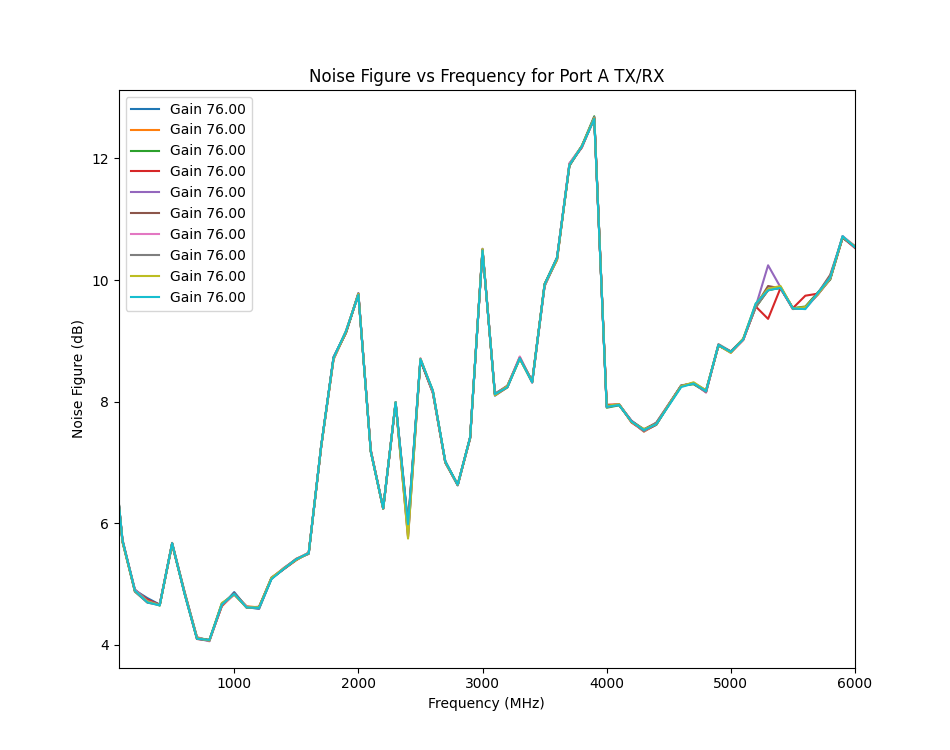

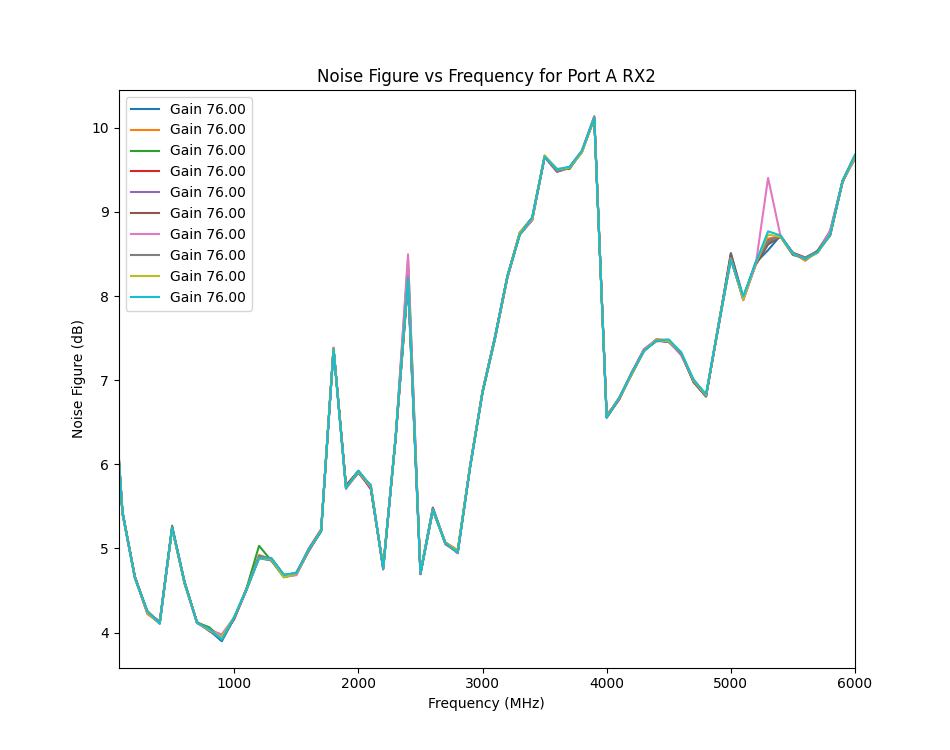

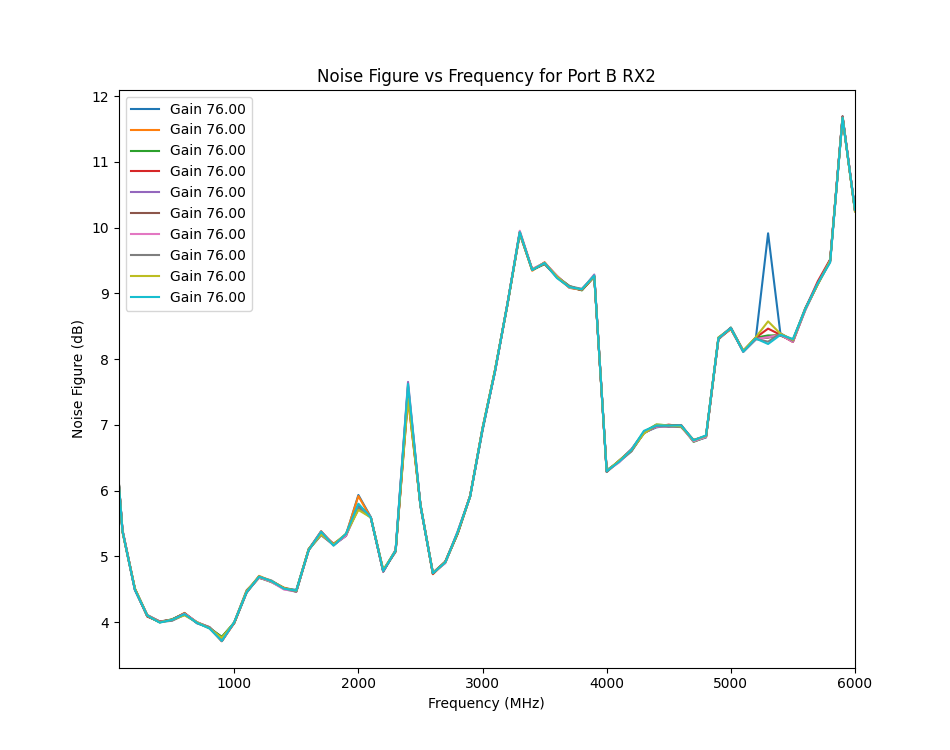

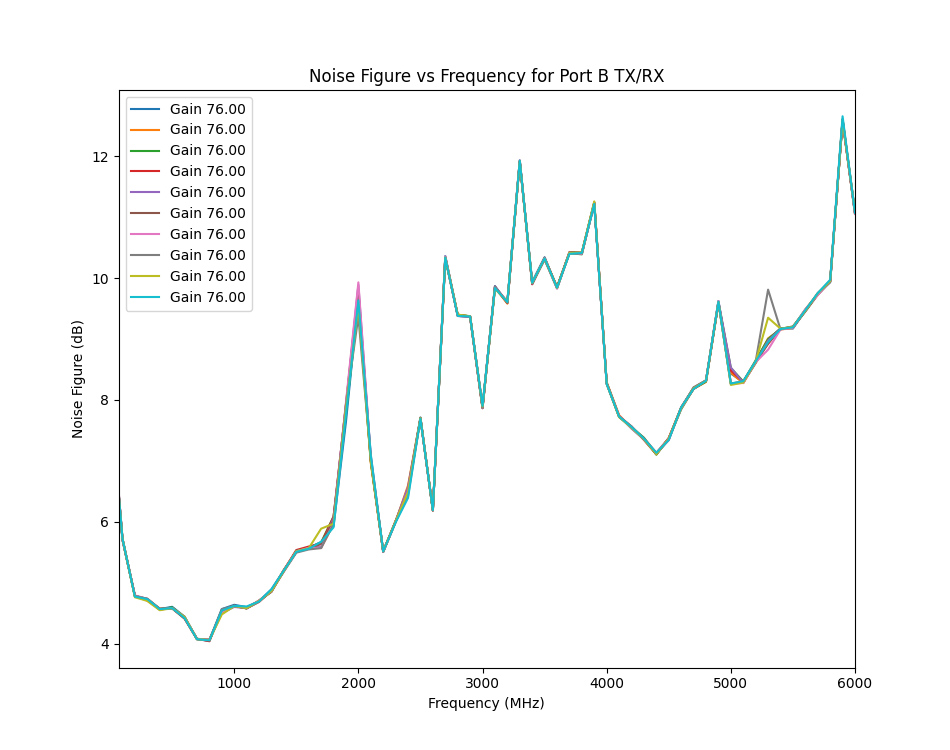

In [1]:
%matplotlib widget

import os
import sys
import statistics

import matplotlib.pyplot

from ldb.hdf5.high_level import HDF5File
from ldb.hdf5._hdf5 import lib as hdf5_lib

def make_fig(width=9.5, height=7.5):
    return matplotlib.pyplot.figure(figsize=(width, height))

def make_xy_ax(fig, title, ylabel, xmin, xmax):
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if xmin is not None and xmax is not None:
        ax.set_xlim(left=xmin, right=xmax)
    return ax


ports = [(0, "TX/RX", "A TX/RX"),
         (0, "RX2", "A RX2"),
         (1, "RX2", "B RX2"),
         (1, "TX/RX", "B TX/RX")]

frequencies = [70e6] + [100e6*i for i in range(1, 61)]
frequencies = [frequency/1e6 for frequency in frequencies]
gains = [50, 60, 75, 76]

repeat_count = 10

# More info at https://gitlab.flux.utah.edu/alex_orange/sdr-calibration-scripts/blob/master/noise_figure.py

calibration_filename = "/calibration-data/nf_317371C_.h5"
if os.path.exists(calibration_filename):
    with HDF5File.open(calibration_filename, read_only=True) as data_file:
        # Indices are (port, frequency, gain, measurement (10 individual pieces of data))
        with data_file.open_dataset('nf_all_frequency_dataset') as dataset:
            data = dataset[...]
            
            for i, port in zip(range(data.size[0]), ports):
                curves = []
                curve_errors = []
                for k in range(data.size[2]):
                    curve = []
                    curve_error = []
                    for l in range(data.size[3]):
                        curve2 = []
                        for j in range(data.size[1]):
                            curve2.append(dataset[i, j, k, l])
                        curve.append(curve2)
                    curves.append(curve)

                fig = make_fig()
                ax = make_xy_ax(fig, 'Noise Figure vs Frequency for Port %s'%(port[2]),
                                'Noise Figure (dB)', frequencies[0], frequencies[-1])
                
                for curve, gain in zip(curves, gains):
                    if gain in [76]:
                        for curve2 in curve:
                            ax.plot(frequencies, curve2, label="Gain %.2f"%(gain))
                    
                ax.legend()
            
else:
    print("File doesn't exist")